# Import Library

In [21]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Path Directory

In [22]:
data_path = "./Images/Data/"
target_path = "./Images/Object.png"

# Preprocessing Function

In [23]:
def preprocess_v1(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ev = cv2.equalizeHist(grey)
    median_blur = cv2.medianBlur(ev, 5)
    return median_blur

def preprocess_v2(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ev = cv2.equalizeHist(grey)
    gaussian_blur = cv2.GaussianBlur(ev, (3, 3), 0)
    return gaussian_blur

# Best Find Match

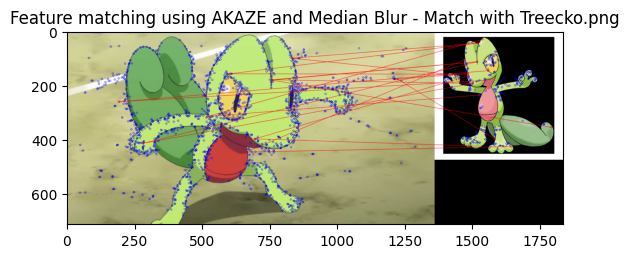

In [ ]:
def find_best_match(prep_func, target_path, data_path, algorithm="AKAZE", title="Median Blur"):

    target_img = cv2.imread(target_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    target_grey = prep_func(target_img)

    if algorithm == "ORB":
        descriptor = cv2.ORB.create()
    elif algorithm == "AKAZE":
        descriptor = cv2.AKAZE.create()
    elif algorithm == "SIFT":
        descriptor = cv2.SIFT.create()

    target_keypoints, target_desc = descriptor.detectAndCompute(target_grey, None)

    if algorithm == "ORB":
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    else:
        matcher = cv2.FlannBasedMatcher(indexParams=dict(algorithm=1, tree=5), searchParams=dict(check=50))
        target_desc = np.float32(target_desc)

    best_match = 0
    best_match_data = {}
    best_file_name = ""

    for img_path in os.listdir(data_path):

        img = cv2.imread(data_path + img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_grey = prep_func(img)

        img_keypoints, img_desc = descriptor.detectAndCompute(img_grey, None)

        if algorithm != "ORB":
            img_desc = np.float32(img_desc)

        matches = matcher.knnMatch(target_desc, img_desc, k=2)
        matches_mask = [[0, 0] for _ in range(len(matches))]

        curr_match = 0

        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                curr_match += 1
                matches_mask[i] = [1, 1]

        if curr_match > best_match:
            best_match = curr_match
            best_match_data = {
                "image" : img,
                "img_path": img_path,
                "keypoints": img_keypoints,
                "desc": img_desc,
                "matches": matches,
                "best_match": best_match,
                "matches_mask": matches_mask
            }
            best_file_name = img_path

    
    result = cv2.drawMatchesKnn(target_img, target_keypoints, best_match_data["image"], best_match_data["keypoints"], best_match_data["matches"], None, matchColor=[255, 0, 0], singlePointColor=[0, 0, 255], matchesMask=best_match_data["matches_mask"])

    plt.figure()
    plt.imshow(result)

    plt.title(f"Feature matching using {algorithm} and {title} - Match with {best_file_name}")
    plt.show()

find_best_match(preprocess_v1, "./Images/Object.png", "./Images/Data/", "AKAZE", "Median Blur")